In [1]:
%%html
<link rel= "stylesheet" type= "text/css" href= "style.css">

# <div class = "title">Pràctica 1 - El procés de l'aprenentatge automàtic</div>
## <div class = "sub-title">Classificador GatIGos amb Màquines de Vectors de Suport(SVM)</div>
### Aprenentatge automàtic 2024-25

<br><hr>

Antoni Frau Gordiola - 43482642S

# Primeres passes, cerca del millor model

## Funcions auxiliars

<p>Aquests son els primers <em>imports</em> i funcions auxiliars per obtenció d'anotacions, dibuixat d'imatges, etc. Part d'aquest material ha estat proporcionat pels professors de l'assignatura.</p>

In [2]:
import os
import numpy as np
import random
import imageio.v2 as imageio
import xml.etree.ElementTree as etree
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split

In [3]:
#Parsetja el fitxer xml i recupera la informació necessaria per trobar la cara de l'animal
#
def extract_xml_annotation(filename):
    """Parse the xml file
    :param filename: str
    :return annotation: diccionari
    """
    z = etree.parse(filename)
    objects = z.findall('./object')
    size = (int(float(z.find('.//width').text)), int(float(z.find('.//height').text)))
    dds = []
    for obj in objects:
        dds.append(obj.find('name').text)
        dds.append([int(float(obj.find('bndbox/xmin').text)),
                                      int(float(obj.find('bndbox/ymin').text)),
                                      int(float(obj.find('bndbox/xmax').text)),
                                      int(float(obj.find('bndbox/ymax').text))])

    return {'size': size, 'informacio': dds}

In [4]:
# Selecciona la cara de l'animal i la transforma a la mida indicat al paràmetre mida_desti
def retall_normalitzat(imatge, dades, mida_desti=(64,64)):
    """
    Extreu la regió de la cara (ROI) i retorna una nova imatge de la mida_destí
    :param imatge: imatge que conté un animal
    :param dades: diccionari extret del xml
    :mida_desti: tupla que conté la mida que obtindrà la cara de l'animal
    """
    x, y, ample, alt = dades['informacio'][1]
    retall = np.copy(imatge[y:alt, x:ample])
    return resize(retall, mida_desti)

In [5]:
def obtenir_dades(carpeta_imatges, carpeta_anotacions, mida=(64, 64)):
    """Genera la col·lecció de cares d'animals i les corresponents etiquetes
    :param carpeta_imatges: string amb el path a la carpeta d'imatges
    :param carpeta_anotacions: string amb el path a la carpeta d'anotacions
    :param mida: tupla que conté la mida que obtindrà la cara de l'animal
    :return:
        images: numpy array 3D amb la col·lecció de cares
        etiquetes: llista binaria 0 si l'animal és un moix 1 en cas contrari
    """

    imatges_elements = [entry for entry in os.listdir(carpeta_imatges) 
                    if os.path.isfile(os.path.join(carpeta_imatges, entry)) 
                    and entry.lower().endswith('.png')]
    
    n_elements = len(imatges_elements)
    # Una matriu 3D: mida x mida x nombre d'imatges
    imatges = np.zeros((mida[0], mida[1], n_elements), dtype=np.float16)
    # Una llista d'etiquetes
    etiquetes = [0] * n_elements

    #  Recorre els elements de les dues carpetes: llegeix una imatge i obté la informació interessant del xml
    for idx, element in enumerate(imatges_elements):
        nom = element.split(".")
        nom_fitxer = nom[0] + ".xml"

        path_anotacio = os.path.join(carpeta_anotacions, nom_fitxer)
        imatge_path = os.path.join(carpeta_imatges, element)
        #imatge = imageio.imread(imatge_path, as_gray=True)
        imatge = imageio.imread(imatge_path, mode='L')
        anotacions = extract_xml_annotation(path_anotacio)
        
        cara_animal = retall_normalitzat(imatge, anotacions, mida)
        tipus_animal = anotacions["informacio"][0]
        
        imatges[:, :, idx] = cara_animal
        etiquetes[idx] = 0 if tipus_animal == "cat" else 1

    return imatges, etiquetes

In [6]:
def obtenirHoG(imatges, hogParams):
    """
    Genera les característiques i imatges dels gradients del corresponent histogram of gaussians
    :param imatges: col·lecció d'imatges de les quals es vol generar el vector de característiques
    :param hogParams: col·lecció dels 3 paràmentres de hog(pixels_per_cell, orientations, cells_per_block)
    :return:
        descriptors: descriptors de hog de les imatrges
        imatges_hog: imatges que representen els gradients
    """

    pixels_bloc = (hogParams[0], hogParams[0])
    orientacions = hogParams[1]
    blocs = (hogParams[2], hogParams[2])

    descriptors = []
    imatges_hog = []

    for idx in range(imatges.shape[0]):

        imatge = imatges[idx, :, :]
        descriptor, imatge_hog = hog(imatge,
                                 orientations=hogParams[1],
                                 pixels_per_cell=(hogParams[0], hogParams[0]),
                                 cells_per_block=(hogParams[2], hogParams[2]),
                                 block_norm='L2-Hys',
                                 visualize=True,
                                 transform_sqrt=True)
        
        descriptors.append(descriptor)
        imatges_hog.append(imatge_hog)

    descriptors = np.array(descriptors)   
    imatges_hog = np.array(imatges_hog)
    
    return descriptors, imatges_hog

In [7]:
def showHoGVariations(imatge, hogParams, mida_imatge):
    """
    Genera una imatge amb característiques i imatges dels gradients de varis histograms of gaussians segons els paràmetres
    :param imatge: col·lecció d'imatges de les quals es vol generar els distints gradients de hog
    :param hogParams: col·lecció dels 3 paràmentres de hog(pixels_per_cell, orientations, cells_per_block)
    :param mida_imatge: mida de la visualització de les imatges i gradients de hog
    """
    
    fig, axes = plt.subplots(1, len(hogParams)+1, figsize=(mida_imatge, mida_imatge))

    axes[0].imshow(imatge, cmap='gray')
    axes[0].axis('off')
    
    for idx2, params in enumerate(hogParams):

        pixels_bloc = (params[0], params[0])
        orientacions = params[1]
        blocs = (params[2], params[2])
        
        descriptors, imatge_hog = hog(imatge,
                                 orientations=params[1],
                                 pixels_per_cell=(params[0], params[0]),
                                 cells_per_block=(params[2], params[2]),
                                 block_norm='L2-Hys',
                                 visualize=True,
                                 transform_sqrt=True)

        axes[idx2+1].imshow(imatge_hog, cmap='gray')
        axes[idx2+1].set_title(f"{len(descriptors)} {params}")
        axes[idx2+1].axis('off')

    plt.tight_layout()
    plt.show()

## Obtenció del conjunt de dades

Primer de tot es carreguen les imatges i anotacions corresponents, i amb una mida adequada (es considera que 128 és suficient per interpretar-ho tant el model com l'humà).

El que es fa abans d'entrenar el model final, és cercar els millors paràmetres de les configuracions pels models amb **linear**, **RBF** i **poly**. S'avança que aquests seran els models amb es que es realitzarà la pràctica. Per triar aquests millors paràmetres es farà la cerca exhaustiva amb **k-fold** i **GridSearch**, i per tant el més raonable és cercar la millor configuració amb un subconjunt de les dades inicials. S'ha fet una cerca amb aproximadament el **20%** del total, i per fer aquesta separació s'ha usat `train_test_split`. D'aquesta forma es genera `sub_imatges`, que representarà el subconjunt de les dades totals per a la cerca dels paràmetres. Es destaca que sempre que s'usi aquesta terminologia(*sub*)) fa referència al subconjunt del 20%.

In [8]:
carpeta_images = "gatigos/images"  # NO ES POT MODIFICAR
carpeta_anotacions = "gatigos/annotations"  # NO ES POT MODIFICAR
mida = (64, 64)

imatges, etiquetes = obtenir_dades(carpeta_images, carpeta_anotacions, mida)

In [9]:
imatges = np.transpose(imatges, (2, 0, 1))
_, sub_imatges, _, sub_etiquetes = train_test_split(imatges, etiquetes, test_size=0.2, random_state=42)
# sub_imatges = np.transpose(sub_imatges, (1,2,0))
# nota: per poder dividir bé les imatges, es transposen i tornen a la seva forma original amb np.transpose

## Recerca i estudi de HoG

El següent, ja que com s'ha explicat a l'assignatura l'avenç amb l'ús de característiques per entrenar els models d'intel·ligència artificial, deriva en usar altres característiques que no siguin els mateixos píxels de les imatges. Una altra forma és usar els descriptors del *Histogram of Gaussians*(HoG), molt útil per entendre les voreres i formes de les imatges. I aquest és el següent pas, entendre com obtenir bons descriptors de HoG.

Una forma de veure-ho, és amb la funció auxiliar `showHoGVariations` implementada, que donada una imatge mostra representacions de HoG segons els llistats de les característiques que també es passen per paràmetre. A continuació es processaran <span class= "pending">X</span> imatges amb els paràmetres de HoG.

També, com a títol de les imatges, s'inca el nombre de descriptors que resulten (un procés de HoG més el·laborat dona més descriptors) i els paràmetres del HoG corresponent. En aquest odre, es mostren les dades:

- Nombre de píxels per cel·la
- Nombre discret d'orientacions
- Nombre de cel·les per bloc

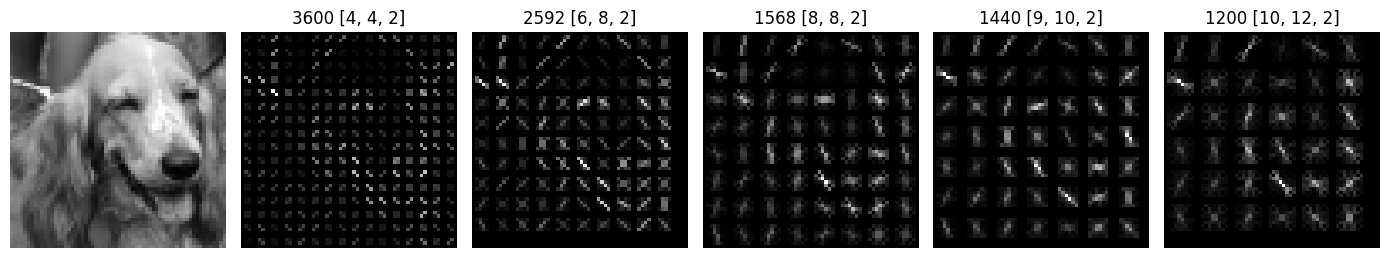

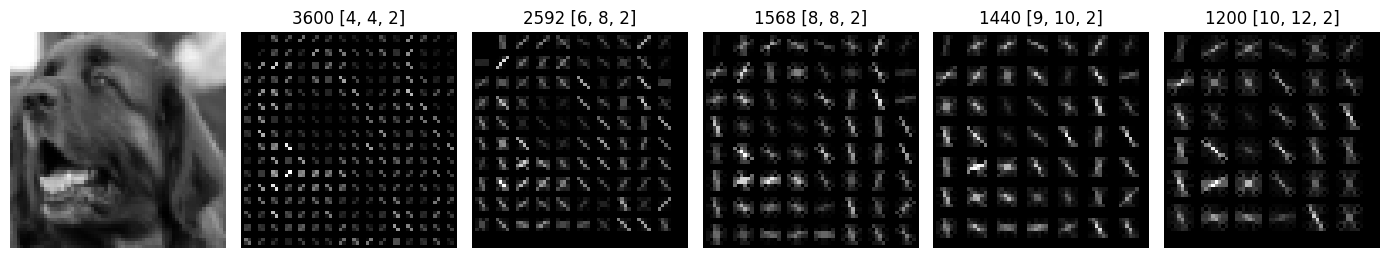

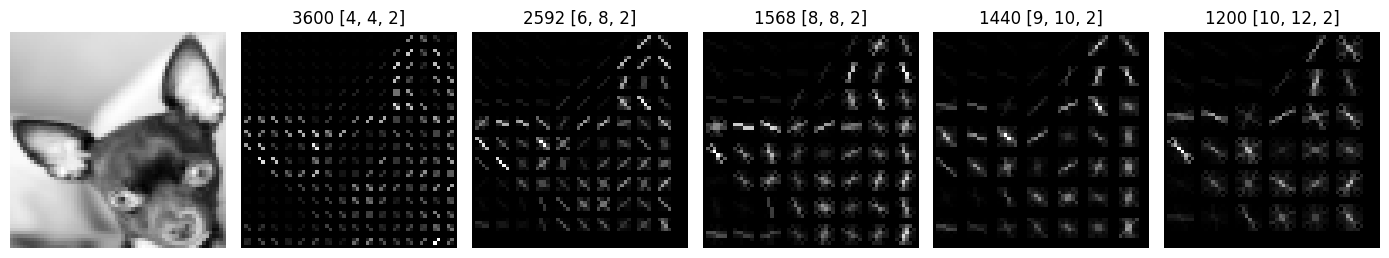

In [10]:
size_imatge = 14
hog_params_prova = [[4, 4, 2], 
                    [6, 8, 2],
                    [8, 8, 2],
                    [9, 10, 2], 
                    [10, 12, 2]]
for i in range(3):
    randomIdx = random.randint(0,len(imatges)-1)
    showHoGVariations(imatges[randomIdx, :, :], hog_params_prova, size_imatge)

hog_parametres = [8, 8, 2]

Vists els resultats a les imatges, visualment i en quantitat de característiques té sentit triar els paràmetres de la tercera columna de HoG. Amb aquest, que usa `pixels_per_cell=8`, `orientations=8` i `cells_per_block=2`, es veu uns gradients prou definits i representatius de la imatge original. A més, la quantitat de descriptors/característiques és de <span class="pending">X</span>, el qual és bastant reduït, comparat amb les <span class="pending">X</span> característiques que s'usarien amb les imatges originals de <span class="pending">XxX</span>.

També és clar que es podria entrenar el model amb diferents sortides de HoG i cercar el millor resultat, però no s'ha considerat a la pràctica.

Ara el següent pas és, amb els paràmetres triats, obtenir les característiques/descriptors HoG de les imatges per entrenar i estudiar els models:

In [11]:
# aquest codi s'ha usat durant el desenvolupament de la pràctica, no està destinat a executarse
# guarda o llegeix les característiques generades a un fitxer
# format: saves/midaImatges_pixelsBloc_orientacions_blocs_nImatges/idx.npz

# 0 = calcular | 1 = guardar | 2 = calcular i guardar | 3 = llegir
accio = 2
hog_text = '_'.join(map(str, hog_parametres))
hog_text = f'{hog_parametres}'

ruta_guardat = f'saves/{mida[0]}_{hog_text}_{imatges.shape[0]}'
os.makedirs(ruta_guardat, exist_ok=True)


if accio == 0:
    print(f'L\'operació es faria a la ruta: {ruta_guardat}, però les dades es calculen')
    descriptors, imatges_hog = obtenirHoG(imatges, hog_parametres)
elif accio == 1 or accio == 2:
    if accio == 2:
        descriptors, imatges_hog = obtenirHoG(imatges, hog_parametres)
    
    ruta_guardat = f'{ruta_guardat}/{sum(1 for entry in os.listdir(ruta_guardat))+1}.npz'
    print(f'L\'escritura es fa a la ruta: {ruta_guardat}')
    np.savez(ruta_guardat, 
             caract=descriptors, 
             imgs_hog=imatges_hog)
elif accio == 2:
    ruta_guardat = f'{ruta_guardat}/{sum(1 for entry in os.listdir(ruta_guardat))}.npz'
    print(f'La lectura es fa a la ruta: {ruta_guardat}')
    dades = np.load(ruta_guardat)
    descriptors = dades['caract']
    imatges_hog = dades['imgs_hog']

L'escritura es fa a la ruta: saves/64_[8, 8, 2]_3686/1.npz


In [12]:
_, sub_descriptors, _, sub_imatges_hog = train_test_split(descriptors, imatges_hog, test_size=0.2, random_state=42)

# Models de classificació i hiperparàmetres

## Quins paràmetres triar?

Una vegada es tenen totes les dades per fer l'entrenament i cerca dels millors paràmetres amb k-fold i GridSearch, es pot començar amb el procés. Primer fent les corresponents divisions en dades de train i test, l'estandarització de les dades, triar els diccionaris de recerca de paràmetres i, finalment, entrenar els subconjunts de les imatges per comparar quins hiperparàmetres són més efectius.

Just seguit es troben els <em>imports</em> corresponents, necessaris per a totes les funcions que s'usaran, principalment relacionades amb contingut de **sklearn**.

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from scipy.spatial import distance_matrix
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import GridSearchCV
from IPython.display import display, Markdown

Aquí es fa la divisió de les dades d'entrada en train i test. S'usa també `train_test_split`, i he decidit posar un **67%** en mostres d'entrenament i **33%** en test. Les nomenclatures segueixen la norma anterior d'usar *sub* per indicar que és el subconjunt del 20%, i a més, train i test per indicar que pertanyen al conjunt de train i test respectivament.

A més, de la següent forma també se separen les imatges visuals i de hog amb el mateix criteri. Això es fa per poder tenir resultats visuals més endavant.

In [14]:
sub_X_train, sub_X_test, sub_y_train, sub_y_test = train_test_split(sub_descriptors, sub_etiquetes, test_size=0.33, random_state=42)
sub_imatges_train, sub_imatges_test, sub_imghog_train, sub_imghog_test = train_test_split(sub_imatges, sub_imatges_hog, test_size=0.33, random_state=42)

Aquí s'estandaritzen les dades amb un `StandardScaler`

In [15]:
scaler = StandardScaler() #MinMaxScaler()  
sub_X_train_transformed = scaler.fit_transform(sub_X_train)
sub_X_test_transformed = scaler.transform(sub_X_test)

Aquí es trien els diferents diccionaris de paràmetres per a la cerca del millor model de classificació amb SVC. L'estructura és una llista amb els tres diccionaris corresponents als models amb ell kernels *linear*, *rbf* i *poly* respectivament, separats en 3 línies diferents.

Quins són els motius de l'elecció dels paràmetres i dels valors? Per a cada kernel:

### Linear

$$ K_{linear} (x,z) = x \cdot z $$

#### C
Aquest és l'únic que controla la variació d'aquest kernel, i representa la penalització i, per tant, la correcció del model. Això vol dir que amb valors massa alts ajusta més els errors i, en conseqüència, pot provocar *overfitting*. Lògicament, amb valors menors no ajusta tant a l'error i, per tant, generalitza més. I també per aquestes raons és important no tenir valors massa grans ni massa petits. En general, per aquest problema, com l'overfitting seria un problema més greu (el conjunt d'imatges no és tan gran i les diferències entre cans i moixos poden ser molt poques) he triat un rang de valors més petits com 0.0001 fins a 1000.

### RBF / Gaussià

Aquest genera un model que ja no és lineal, i cal destacar que és el kernel per defecte de `SVC`.

$$ K_{RBF}(x,z) = exp(-\gamma||x-z||^2) $$

#### C
Aquesta C comparteix el significat amb el kernel linear, ja que també representa la penalització. Els canvis més notables venen, perquè aquest no és l'únic paràmetre que es pot modificar, i per tant per reduir les exponencials combinacions he rebaixat el rang de possibles valors. No fan falta valors tan extrems, i per això els valors descartats han estat el més petit i el més gran, en relació amb l'anterior.
#### Gamma
Aquest paràmetre apareix en els kernels no lineals, i regeix la forma en la qual influeixen les mostres en l'entrenament. Amb valors més alts, els punts, i els suports, tenen més importància i els límits de la classificació s'ajusten més a les dades. En canvi, amb valors més baixos permet generalitzar en la classificació. En aquest cas els valors triats van d'un rang més baix, del 1e-1 al 1e-5 (no passa per tots els valors intermedis), i incloent també *auto* i *scale*. Aquests dos darrers es calculen internament de forma que el primer s'ajusta al nombre de característiques $ \frac{1}{n\_caract} $ i el segon també i a més amb la seva variança $ \frac{1}{n\_caract × x.var()} $.

### Poly

$$ K_{poly}(x,z) = (\gamma \, x \cdot z + \text{coef0})^2 $$

#### C
També es comparteix el paràmetre C com les dues anteriors vegades. Es pot destacar que també està reduït respecte al kernel lineal perquè hi ha altres paràmetres i les combinacions finals creixen exponencialment.
#### Gamma
Aquest també es comparteix, aquest cas amb RBF, de forma que representa l'impacte de cada mostra dins la classificació. Aquí també s'han reduït els valors a usar, com en el valor 0.1, perquè és un extrem amb un valor bastant elevat, no molt útil quan se cerca un model que té unes característiques que no són sempre exactes per a tots els cans/moixos.
#### Degree
Un nou paràmetre que afecta aquest tipus de kernel. Com és clar, regeix el grau del polinomi, i, com més elevat més complex i permet classificacions més variades. Valors comuns que es poden usar per no excedir-se són del 2 al 5 (amb 1 el model és lineal), encara que el 5 no s'ha usat per mantenir compromís amb el temps d'entrenament.
#### Coef0
El darrer paràmetre és rellevant quan el model és d'aquest tipus, polinòmic. Com també es pot veure a la funció, representa el terme independent, constant i que també és característic de les funcions polinòmiques. Valors útils per estudiar el rendiment del model són del 0 (funció sense desplaçament) fins a realment qualsevol no molt exagerat. Jo concretament he afegit l'1 i el 10.

In [16]:
kernels = ["linear", "rbf", "poly"]
parameters_set = [{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
                  {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.1, 0.01, 0.001, 0.00001]},
                  {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': ['scale', 'auto', 0.01, 0.001, 0.0001], 'degree': [2, 3, 4], 'coef0': [0, 1, 10]}]

## Triar la millor configuració de paràmetres

Per fer la cerca, com ja s'ha comentat anteriorment s'usa `GridSearchCV`, on aquest es pot entrenar amb el model i el diccionari de paràmetres adequat. En acabar, es pot obtenir el millor estimador `best_estimator_`, que és la pròpia configuració del model de classificació.

Per a tot el procés, es fa la cerca per als 3 kernels dins un bucle, i es van registrant els millors estimadors de cada model així com les seves puntuacions (demanades a l'enunciat de la pràctica) que indiquen el resultat de fer *k-fold cross-validation*. Aquestes mètriques són la precisió(**precision**), sensitivitat(**recall**) i especifitat(**F1**).

In [17]:
best_estimators = [{},{},{}]
precisions = [0,0,0]
recalls = [0,0,0]
f1s = [0,0,0]

for idx, kernel in enumerate(kernels):
    svm = SVC(kernel=kernel)
    clf = GridSearchCV(svm, parameters_set[idx], cv=3)
    
    clf.fit(sub_X_train_transformed, sub_y_train)

    print(f"Millor model {kernel} amb:", clf.best_estimator_)
    best_estimators[idx] = clf.best_estimator_
    resultats = clf.best_estimator_.predict(sub_X_test_transformed)
    
    precisions[idx] = precision_score(sub_y_test, resultats)
    recalls[idx] = recall_score(sub_y_test, resultats)
    f1s[idx] = f1_score(sub_y_test, resultats)
    print(classification_report(sub_y_test, resultats))

Millor model linear amb: SVC(C=0.01, kernel='linear')
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        87
           1       0.89      0.91      0.90       157

    accuracy                           0.87       244
   macro avg       0.86      0.85      0.86       244
weighted avg       0.87      0.87      0.87       244

Millor model rbf amb: SVC(C=10)
              precision    recall  f1-score   support

           0       0.90      0.76      0.82        87
           1       0.88      0.96      0.91       157

    accuracy                           0.89       244
   macro avg       0.89      0.86      0.87       244
weighted avg       0.89      0.89      0.88       244

Millor model poly amb: SVC(C=0.01, coef0=1, degree=2, gamma=0.01, kernel='poly')
              precision    recall  f1-score   support

           0       0.93      0.74      0.82        87
           1       0.87      0.97      0.92       157

    accuracy   

In [18]:
taulta_resultats = f"""
|                 |         **Precisió**           |    **Sensitivitat**    |     **Especifitat**     |
|---------------- | ----------------------------- | ----------------------- | ---------------------- |
| **Model lineal** |   {round(precisions[0], 3)}   |  {round(recalls[0], 3)}  |  {round(f1s[0], 3)}   |
| **Model RBF** |   {round(precisions[1], 3)}   |  {round(recalls[1], 3)}  |  {round(f1s[1], 3)}   |
| **Model plonòmic** |   {round(precisions[2], 3)}   |  {round(recalls[2], 3)}  |  {round(f1s[2], 3)}   |
"""

display(Markdown(taulta_resultats))


|                 |         **Precisió**           |    **Sensitivitat**    |     **Especifitat**     |
|---------------- | ----------------------------- | ----------------------- | ---------------------- |
| **Model lineal** |   0.888   |  0.911  |  0.899   |
| **Model RBF** |   0.877   |  0.955  |  0.915   |
| **Model plonòmic** |   0.869   |  0.968  |  0.916   |


In [19]:
best_params = best_estimators[f1s.index(max(f1s))].get_params()
print(f'Els millors paràmetres pel model de classificació són: {best_estimators[f1s.index(max(f1s))]}')

Els millors paràmetres pel model de classificació són: SVC(C=0.01, coef0=1, degree=2, gamma=0.01, kernel='poly')


# Test sencer

Ja amb totes les dades d'entrenament, elegits els paràmetres de HoG per extreure els descriptors corresponents, i els hiperparàmetres del millor model amb el subconjunt de dades, es pot construir i testejar el model final.

A partir d'aquí es repeteix i s'unifica tot el procés anterior amb les dades corresponents. La diferència principal és que al final es recullen 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(descriptors, etiquetes, test_size=0.33, random_state=42)
imatges_train, imatges_test, imghog_train, imghog_test = train_test_split(imatges, imatges_hog, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

svc = SVC(**best_params)
svc.fit(X_train_transformed, y_train)
prediccio = svc.predict(X_test_transformed)

precisio = precision_score(y_test, prediccio)
recall = recall_score(y_test, prediccio)
f1 = f1_score(y_test, prediccio)
print(f"   Precisió: {precisio}")
print(f"   Sensitivitat: {recall}")
print(f"   F1: {f1}")

   Precisió: 0.9362214199759326
   Sensitivitat: 0.958128078817734
   F1: 0.9470480827754109


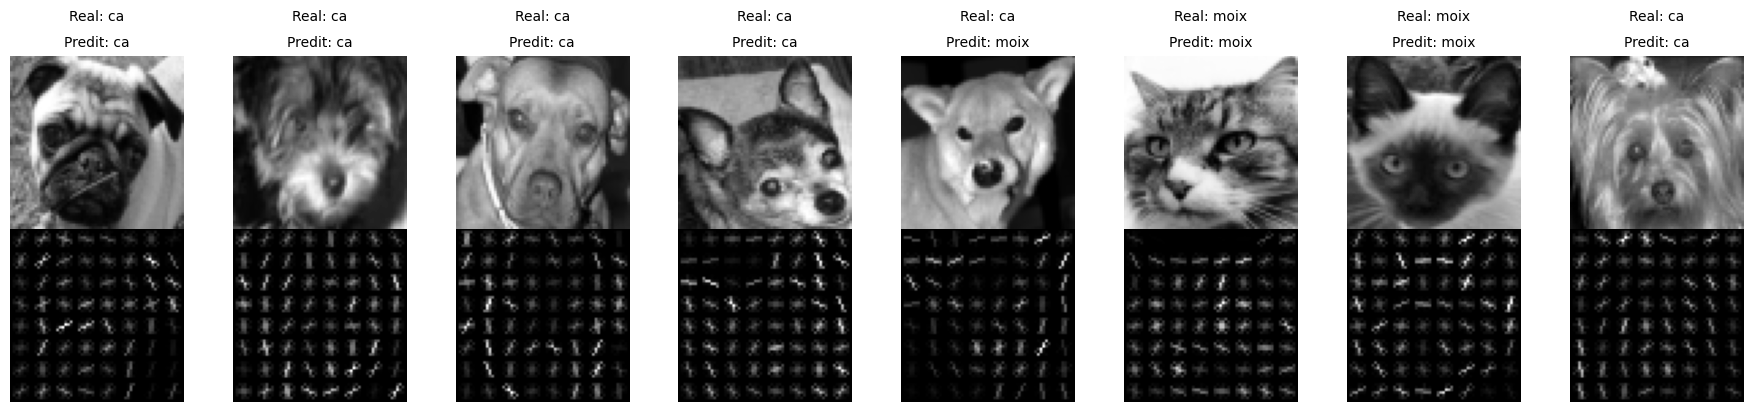

In [21]:
n_imatges = 8
# 71
randomIdx = random.randint(0,len(imatges)-n_imatges)
fig_size = 23
fig, axes = plt.subplots(2, n_imatges, figsize=(fig_size, 4.5))

for idx, i in enumerate(range(randomIdx, randomIdx + n_imatges)):
    
    axes[0, idx].imshow(imatges_test[i,:,:], cmap='gray')
    axes[0, idx].axis('off')
    axes[0, idx].text(0.5, 1.2, f"Real: {'moix' if y_test[i] == 0 else 'ca'}", ha='center', transform=axes[0, idx].transAxes)
    axes[0, idx].text(0.5, 1.05, f"Predit: {'moix' if prediccio[i] == 0 else 'ca'}", ha='center', transform=axes[0, idx].transAxes)
    
    axes[1, idx].imshow(imghog_test[i,:,:], cmap='gray')
    axes[1, idx].axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.show()